<a href="https://colab.research.google.com/github/subikkshas/PREPARE-ALL/blob/main/New_PREPARE_ALL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# STEP 3: Load the dataset
# Replace path with your actual file path in Drive
file_path = "/content/Icicle Pre trial AI paper dataset_anonymised_April 2025.xlsx"
df = pd.read_excel(file_path)

print("Original shape:", df.shape)
print("Columns in dataset:\n", df.columns.tolist())

# STEP 4: Define columns to drop
drop_cols = [
    "Sl No",
    "UPN_AI_dataset",
    # All Date columns
    "Date of Birth", "Date of Diagnosis", "Date of Remission_EOI",
    "Date of Completion of treatment", "Date of Relapse",
    "Date of Death ", "Date of Treatment abandonment/ Disease progresssion/Off protocol",
    "Date of Last FU",
    # Relapse & outcome details
    "Time-point of Relapse ", "Type of relapse", "Site of Relapse ",
    "Death", "Treatment death phase",
    "Treatment abandonment/Disease progresssion/Off protocol",
    "Current status at Last Follow up "
]

# STEP 5: Drop columns safely (only if present in df)
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns])

print("After dropping shape:", df_clean.shape)
print("Remaining columns:\n", df_clean.columns.tolist())

Original shape: (2331, 33)
Columns in dataset:
 ['Sl No', 'UPN_AI_dataset', 'Previous Treatment', 'Date of Birth', 'NCI Risk', 'Sex', 'Date of Diagnosis', 'Age', 'Lineage', 'Bulky Disease', 'Highest presenting WBC', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'Date of Remission_EOI', 'Remission status _EOI', 'MRD Status_EOI', 'Final Risk ', 'Date of Completion of treatment', 'Relapsed', 'Date of Relapse', 'Time-point of Relapse ', 'Type of relapse', 'Site of Relapse ', 'Death', 'Date of Death ', 'Treatment death phase', 'Treatment abandonment/Disease progresssion/Off protocol', 'Date of Treatment abandonment/ Disease progresssion/Off protocol', 'Date of Last FU', 'Current status at Last Follow up ']
After dropping shape: (2331, 16)
Remaining columns:
 ['Previous Treatment', 'NCI Risk', 'Sex', 'Age', 'Lineage', 'Bulky Disease', 'Highest presenting WBC', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cy

In [2]:
# Imputaation

import pandas as pd
from sklearn.impute import SimpleImputer

# Assume df_clean is already created after dropping leakage columns
print("Shape before imputation:", df_clean.shape)

# STEP 1: Separate numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# STEP 2: Impute missing values
# Numeric → Median
num_imputer = SimpleImputer(strategy="median")
df_clean[numeric_cols] = num_imputer.fit_transform(df_clean[numeric_cols])

# Categorical → "Unknown"
cat_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")
df_clean[categorical_cols] = cat_imputer.fit_transform(df_clean[categorical_cols])

# STEP 3: Check if missing values remain
print("Remaining missing values per column:\n", df_clean.isnull().sum())

Shape before imputation: (2331, 16)
Numeric columns: ['Age', 'Highest presenting WBC']
Categorical columns: ['Previous Treatment', 'NCI Risk', 'Sex', 'Lineage', 'Bulky Disease', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'Remission status _EOI', 'MRD Status_EOI', 'Final Risk ', 'Relapsed']
Remaining missing values per column:
 Previous Treatment        0
NCI Risk                  0
Sex                       0
Age                       0
Lineage                   0
Bulky Disease             0
Highest presenting WBC    0
Prednisolone Response     0
CNS Disease               0
Cytogenetic groups        0
Detail cytogenetics       0
Provisional risk          0
Remission status _EOI     0
MRD Status_EOI            0
Final Risk                0
Relapsed                  0
dtype: int64


In [3]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Encoding
# === ENCODING FOR MODELING (NO LEAKAGE) ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

# 1) Clean column names
df_work = df_clean.copy()
df_work.columns = df_work.columns.str.strip()

# 2) Target & feature splits
target = "Relapsed"
X = df_work.drop(columns=[target])
y = df_work[target].astype("category").cat.codes  # Yes/No → 0/1

# 3) Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4) Define columns (intersect with actual)
label_cols = ["Provisional risk", "Final Risk"]
te_cols    = ["Detail cytogenetics", "Cytogenetic groups"]
other_cat_cols = [
    "Sex", "Lineage", "Bulky Disease", "Prednisolone Response",
    "CNS Disease", "Remission status _EOI", "MRD Status_EOI", "NCI Risk"
]

label_cols       = [c for c in label_cols if c in X_train.columns]
te_cols          = [c for c in te_cols if c in X_train.columns]
other_cat_cols   = [c for c in other_cat_cols if c in X_train.columns]

# 5) Label-encode (fit on train, transform both)
for col in label_cols + other_cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    # For unseen categories in test, map to -1
    mapping = {label: index for index, label in enumerate(le.classes_)}
    X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)


# 6) Target-encode high-cardinality columns (fit on TRAIN ONLY; transform both)
if len(te_cols) > 0:
    te = TargetEncoder(cols=te_cols, smoothing=0.3)
    X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)
    X_test[te_cols]  = te.transform(X_test[te_cols])

# 7) Save encoded splits for modeling
train_out = "/content/drive/MyDrive/ALL_Relapse_Encoded_train.csv"
test_out  = "/content/drive/MyDrive/ALL_Relapse_Encoded_test.csv"

pd.concat([X_train, y_train.rename(target)], axis=1).to_csv(train_out, index=False)
pd.concat([X_test,  y_test.rename(target)],  axis=1).to_csv(test_out,  index=False)

print(f"✅ Encoding (no leakage) done.\nTrain → {train_out}\nTest  → {test_out}")

✅ Encoding (no leakage) done.
Train → /content/drive/MyDrive/ALL_Relapse_Encoded_train.csv
Test  → /content/drive/MyDrive/ALL_Relapse_Encoded_test.csv


In [6]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.2 MB/s eta 0:00:00


[I 2025-09-09 05:21:03,898] A new study created in memory with name: no-name-c7646736-4e33-4c03-a25d-cc004ac2cba6


Shapes → Train: (1864, 15)  Test: (467, 15)
Class balance (train before SMOTE): Counter({0: 1412, 1: 452})
Class balance (test): Counter({0: 354, 1: 113})
Non-numeric feature columns to encode: ['Previous Treatment']
✅ All features numeric. Proceeding to SMOTE...
Class balance (train after SMOTE): Counter({0: 1412, 1: 1412})


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:21:04] WARNING: /w


Best CV F1: 1.2612200037438541
Best Params: {'n_estimators': 157, 'learning_rate': 0.06894988113803681, 'max_depth': 10, 'min_child_weight': 4, 'subsample': 0.8316738767331029, 'colsample_bytree': 0.7816208757531239, 'gamma': 0.37342455582684386, 'reg_alpha': 0.4719146127396041, 'reg_lambda': 0.7142152595395314}

=== TEST METRICS ===
Accuracy: 0.7430
Precision: 0.4478 | Recall: 0.2655 | F1: 0.3333
ROC AUC: 0.6457

Classification Report:
               precision    recall  f1-score   support

           0     0.7925    0.8955    0.8408       354
           1     0.4478    0.2655    0.3333       113

    accuracy                         0.7430       467
   macro avg     0.6201    0.5805    0.5871       467
weighted avg     0.7091    0.7430    0.7180       467

Confusion Matrix:
 [[317  37]
 [ 83  30]]


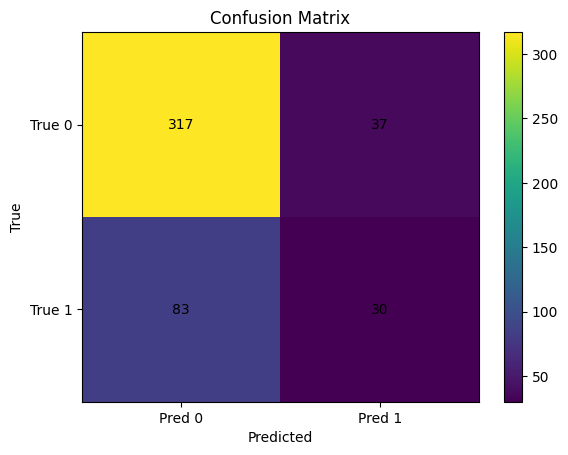

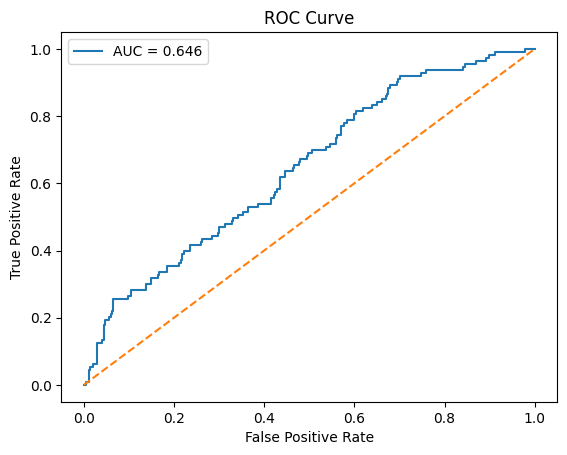


Top 15 Features by Importance:
 Cytogenetic groups        0.173186
Lineage                   0.123847
Detail cytogenetics       0.111123
Final Risk                0.083929
Remission status _EOI     0.057312
Previous Treatment        0.057234
Prednisolone Response     0.056719
MRD Status_EOI            0.053779
Bulky Disease             0.050793
CNS Disease               0.046740
Provisional risk          0.044787
NCI Risk                  0.041180
Age                       0.041114
Highest presenting WBC    0.032086
Sex                       0.026170
dtype: float32


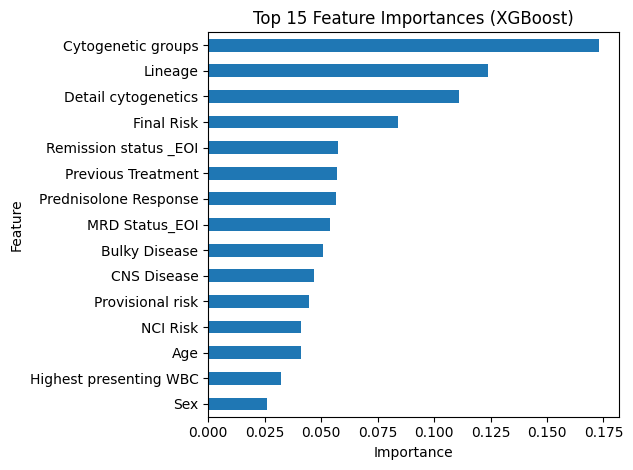

In [10]:
# Train and Test

# ==== ALL-IN-ONE: SMOTE → OPTUNA → XGBOOST → EVAL (COLAB-READY) ====

# --- Imports ---
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, roc_auc_score, f1_score, # Added f1_score
    precision_score, recall_score # Added precision_score and recall_score
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import optuna
import matplotlib.pyplot as plt
# from xgboost.callback import EarlyStopping # Removed this import

# --- File paths (update if needed) ---
train_path = "/content/drive/MyDrive/ALL_Relapse_Encoded_train.csv"
test_path  = "/content/drive/MyDrive/ALL_Relapse_Encoded_test.csv"
target_col = "Relapsed"

# --- Load data ---
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# --- Split X, y ---
X_train = train_df.drop(columns=[target_col]).copy()
y_train = train_df[target_col].copy()
X_test  = test_df.drop(columns=[target_col]).copy()
y_test  = test_df[target_col].copy()

print("Shapes → Train:", X_train.shape, " Test:", X_test.shape)

# --- Ensure y is numeric 0/1 ---
if y_train.dtype == 'O' or str(y_train.dtype).startswith('category'):
    mapping = {'No': 0, 'Yes': 1, 0: 0, 1: 1}
    y_train = y_train.map(mapping).astype(int)
    y_test  = y_test.map(mapping).astype(int)
else:
    y_train = y_train.astype(int)
    y_test  = y_test.astype(int)

print("Class balance (train before SMOTE):", Counter(y_train))
print("Class balance (test):", Counter(y_test))

# --- Make X fully numeric (handle any lingering object/category/bool) ---
non_numeric_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Non-numeric feature columns to encode:", non_numeric_cols)

for col in non_numeric_cols:
    le = LabelEncoder()
    # Fit on train
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    # Map test; handle unseen values
    mapping = {label: index for index, label in enumerate(le.classes_)}
    X_test[col] = X_test[col].astype(str).map(mapping).fillna(-1).astype(int)


# Safety check: force numeric or raise
_ = X_train.apply(pd.to_numeric, errors='raise')
_ = X_test.apply(pd.to_numeric, errors='raise')
print("✅ All features numeric. Proceeding to SMOTE...")

# --- SMOTE on train only ---
minority_count = int((y_train == 1).sum())
k_neighbors = 5 if minority_count > 6 else max(1, minority_count - 1)

smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Class balance (train after SMOTE):", Counter(y_train_res))


# === Optuna objective to maximize F1 (5-fold CV) ===
def objective(trial):

  def custom_metric(y_true, y_pred):

    Precision = precision_score(y_true, y_pred)
    Recall = 3 * recall_score(y_true, y_pred)

    return  2 * (Precision * Recall) / (Precision + Recall)


  params = { # Uncommented this block
      'n_estimators': trial.suggest_int('n_estimators', 100, 500),
      'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 10),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
      'subsample': trial.suggest_float('subsample', 0.6, 1.0),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
      'gamma': trial.suggest_float('gamma', 0.0, 0.5),
      'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
      'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
      'random_state': 42,
      'use_label_encoder': False,
      #'eval_metric': 'logloss',
      'n_jobs': -1,
      'tree_method': 'hist'
  } # Uncommented this block

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  metric = []

  for tr_idx, va_idx in skf.split(X_train_res, y_train_res): # Changed X_train_bal to X_train_res and y_train_bal to y_train_res
      X_tr, X_va = X_train_res.iloc[tr_idx], X_train_res.iloc[va_idx] # Changed X_train_bal to X_train_res
      y_tr, y_va = y_train_res.iloc[tr_idx], y_train_res.iloc[va_idx] # Changed y_train_bal to y_train_res

      model = XGBClassifier(**params)
      model.fit(X_tr, y_tr, verbose=False)
      y_va_pred = model.predict(X_va)
      metric.append(custom_metric(y_va, y_va_pred))

  return float(np.mean(metric))

# === Run study for F1 optimization ===
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=False)

print("\nBest CV F1:", study.best_value)
print("Best Params:", study.best_params)

# --- Train final model on full oversampled train ---
best_params = study.best_params.copy()
final_model = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    use_label_encoder=False
)

# Keep a small validation split from oversampled train for early stopping
X_tr, X_va, y_tr, y_va = train_test_split(
    X_train_res, y_train_res, test_size=0.1, stratify=y_train_res, random_state=42
)
# early_stopping = EarlyStopping(rounds=100, metric_name="auc", data_name="validation_0") # Removed this line

final_model.fit(
    X_train_res, y_train_res, # Changed to use full oversampled data
    # eval_set=[(X_va, y_va)], # Removed this line
    verbose=False,
    # callbacks=[early_stopping] # Removed this line
)

# --- Evaluate on untouched test set ---
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print("\n=== TEST METRICS ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# --- Confusion matrix plot (matplotlib only) ---
plt.figure()
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

# --- ROC curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# --- Top-15 feature importances ---
feat_names = X_train.columns.tolist()
importances = final_model.feature_importances_
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)
print("\nTop 15 Features by Importance:\n", fi)

plt.figure()
fi.iloc[::-1].plot(kind="barh")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb
print(xgb.__version__)

3.0.4


In [ ]:
!pip -q install -U xgboost==2.1.1
import xgboost as xgb, sys
print("xgboost version:", xgb.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.9 MB/s eta 0:00:00
xgboost version: 3.0.4


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# Get probabilities
y_prob = final_model.predict_proba(X_test)[:, 1]

# Adjust threshold
threshold = 0.1
y_pred_custom = (y_prob >= threshold).astype(int)

# === Evaluation Metrics ===
acc = accuracy_score(y_test, y_pred_custom)
prec = precision_score(y_test, y_pred_custom, zero_division=0)
rec = recall_score(y_test, y_pred_custom, zero_division=0)
f1 = f1_score(y_test, y_pred_custom, zero_division=0)
auc = roc_auc_score(y_test, y_prob)  # ROC AUC always uses probs

print(f"\n=== Test Metrics (Threshold={threshold}) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))



=== Test Metrics (Threshold=0.1) ===
Accuracy : 0.4518
Precision: 0.2951
Recall   : 0.9115
F1 Score : 0.4459
ROC AUC  : 0.6405

Classification Report:
              precision    recall  f1-score   support

           0     0.9153    0.3051    0.4576       354
           1     0.2951    0.9115    0.4459       113

    accuracy                         0.4518       467
   macro avg     0.6052    0.6083    0.4518       467
weighted avg     0.7652    0.4518    0.4548       467

Confusion Matrix:
[[108 246]
 [ 10 103]]


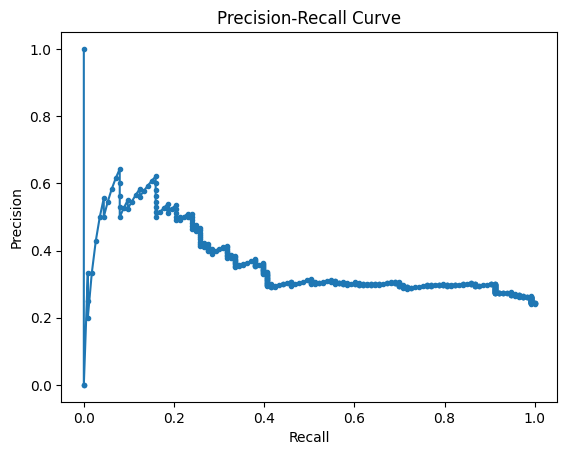

Threshold for Recall ≥ 0.8: 0.01, Precision: 0.24


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_prob)

# Plot PR curve
import matplotlib.pyplot as plt
plt.plot(rec, prec, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Find threshold for desired recall (e.g. ≥0.80)
desired_recall = 0.80
idx = np.argmax(rec >= desired_recall)
print(f"Threshold for Recall ≥ {desired_recall}: {thresh[idx]:.2f}, Precision: {prec[idx]:.2f}")
